# HMMA308, Apprentissage Statistique: Ridge

Auteur: *Joseph Salmon*

Ce notebook reproduit les images du cours "Ridge.pdf"

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  # for plots
from matplotlib import rc
from sklearn.linear_model import RidgeCV
import seaborn as sns
from os import mkdir, path
from mpl_toolkits.mplot3d import Axes3D

# interaction mode better for 3D
%matplotlib notebook

In [2]:
np.random.seed(seed=44)
dirname = "../prebuiltimages/"
imageformat = '.pdf'

if not path.exists(dirname):
    mkdir(dirname)

## Plot initialization


In [3]:
plt.close('all')


rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
(dim1, dim2) = 12, 6
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': True,
          'figure.figsize': (dim1, dim2)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("ticks")
sns.axes_style()

# Display function:

saving = False


def my_saving_display(fig, dirname, filename, imageformat):
    """"Saving with personal function."""
    filename = filename.replace('.', 'pt')  # remove "." to avoid floats issues
    if saving is True:
        dirname + filename + imageformat
        image_name = dirname + filename + imageformat
        fig.savefig(image_name)

## Ridge path / Ridge CV

In [4]:
n_features = 50
n_samples = 51

eps = 1e-6

alpha_max = 1e4
n_alphas = 100
alphas = np.logspace(np.log10(alpha_max * eps),
                     np.log10(alpha_max), num=n_alphas)

# observe the weird phenomenon with such a design matrix X: (uncomment what is next)
# x = 10. ** (-np.arange(n_samples,))
# X = (np.column_stack([x ** (i) for i in range(n_features)]))

X = np.random.randn(n_samples, n_features)
theta_true = np.zeros([n_features, ])
theta_true[0:5] = 2
y_true = np.dot(X, theta_true)
sigma = 1.
noise = sigma * np.random.randn(n_samples,)
y = np.dot(X, theta_true) + noise


def ridge_path(X, y, alphas):
    """ compute the ridge path for a list of tuning parameters """
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    theta_ridge = np.zeros((n_features, n_alphas))
    mat_d = np.zeros((n_features, n_alphas))
    UTy = np.dot(U.T, y)
    for index, alpha in enumerate(alphas):
        mat_d = np.diag((s / (s ** 2 + alpha)))
        coef_alpha = np.dot(Vt.T, np.dot(mat_d, UTy))
        theta_ridge[:, index] = coef_alpha

    return theta_ridge, s


theta_ridge, s = ridge_path(X, y, np.asarray(alphas).ravel())
# Possible alternative
# from sklearn.linear_model import _solve_svd

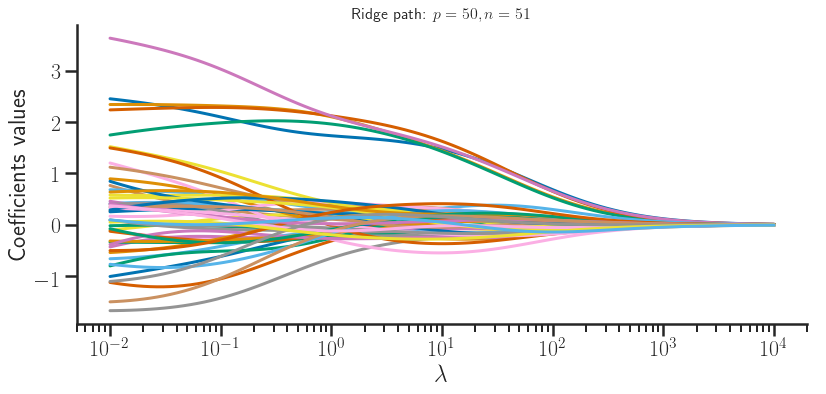

In [5]:
fig2, ax1 = plt.subplots(1, 1)

sns.despine()

plt.title("Ridge path: " +
          r"$p={0}, n={1} $".format(n_features, n_samples), fontsize=16)
ax1.plot(alphas, np.transpose(theta_ridge), linewidth=3)
ax1.set_xscale('log')
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("Coefficients values")
plt.tight_layout()
plt.show()

my_saving_display(fig2, dirname, "Ridge_path", imageformat)

## Cross Validation for Ridge

/home/jo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


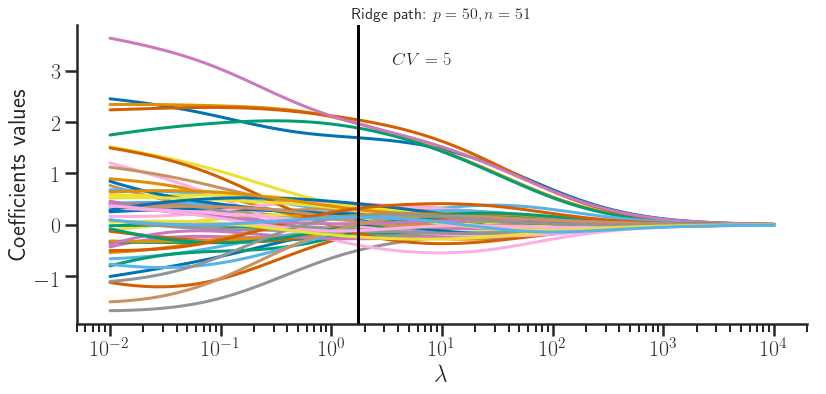

In [6]:
fig3, ax1 = plt.subplots(1, 1)
sns.despine()
plt.title("Ridge path: " +
          r"$p={0}, n={1} $".format(n_features, n_samples), fontsize=16)
ax1.plot(alphas, np.transpose(theta_ridge), linewidth=3)
ax1.set_xscale('log')
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("Coefficients values")

# If cv not specified  GCV (=leave-one-out) is used... seems really bad,
cv_fold = 5
clf = RidgeCV(alphas=alphas, fit_intercept=False, normalize=False, cv=cv_fold)
clf.fit(X, y)
ax1.axvline(x=clf.alpha_, color='K', linestyle='-', linewidth=3)
ax1.annotate('$CV=5$', xy=(2 * clf.alpha_, 0.2), xycoords = 'data',
             xytext = (0, 150), textcoords = 'offset points', fontsize = 18)
plt.tight_layout()
plt.show()
my_saving_display(fig3, dirname, "Ridge_path_CV", imageformat)

## Bias / Variance trade-off

In [7]:
# Bias contribution to the prediction risk
Biais2_tab = np.zeros(np.shape(alphas))
Gram = np.dot(X.T, X)
for index, alpha in enumerate(alphas):
    # Biais2 = np.dot(np.dot(Gram, theta_true),
    #                 np.linalg.solve(np.dot(Gram + alpha * np.eye(n_features),
    #                                 Gram + alpha * np.eye(n_features)),
    #                                 theta_true))
    intermed = alpha * X.dot(np.linalg.solve(Gram + alpha * np.eye(n_features),
                                             theta_true))
    Biais2 = np.linalg.norm(intermed) ** 2
    Biais2_tab[index] = Biais2

# Variance contribution to the prediction risk
Var_tab = np.zeros(np.shape(alphas))

for index, alpha in enumerate(alphas):
    Var_tab[index] = np.sum(s ** 4 / (s ** 2 + alpha) ** 2) * sigma ** 2

Risk = Var_tab + Biais2_tab

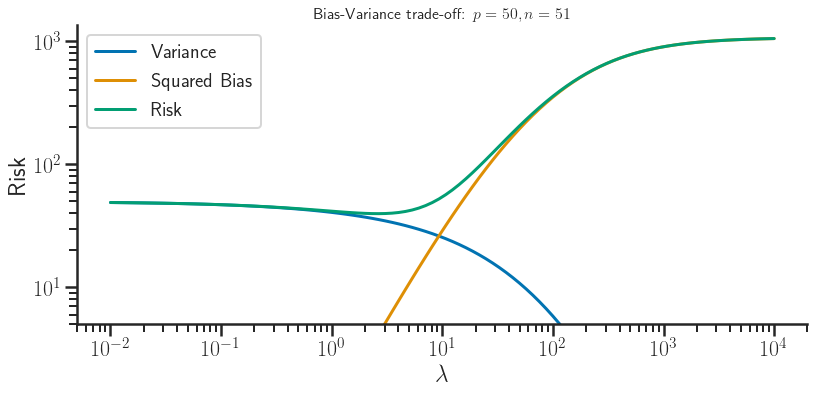

In [8]:
fig1, ax1 = plt.subplots(1, 1)
sns.despine()
plt.title("Bias-Variance trade-off: " +
          r"$p={0}, n={1} $".format(n_features, n_samples), fontsize=16)
ax1.set_ylim([5 * sigma ** 2, Risk[-1] * 1.3])
plt.loglog(alphas, Var_tab, label="Variance", linewidth=3)
plt.loglog(alphas, Biais2_tab, label="Squared Bias", linewidth=3)
plt.loglog(alphas, Risk, label="Risk", linewidth=3)
plt.xlabel('$\lambda$')
plt.ylabel("Risk")
plt.legend(loc="upper left", fontsize=20)
plt.tight_layout()
plt.show()
my_saving_display(fig1, dirname, "Bias_variance_trade_off", imageformat)


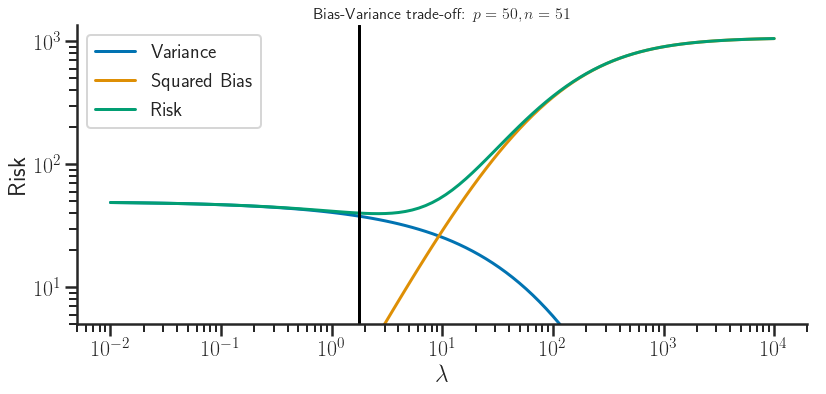

In [9]:
fig1, ax1 = plt.subplots(1, 1)
sns.despine()
plt.title("Bias-Variance trade-off: " +
          r"$p={0}, n={1} $".format(n_features, n_samples), fontsize=16)
ax1.set_ylim([5 * sigma ** 2, Risk[-1] * 1.3])
plt.loglog(alphas, Var_tab, label="Variance", linewidth=3)
plt.loglog(alphas, Biais2_tab, label="Squared Bias", linewidth=3)
plt.loglog(alphas, Risk, label="Risk", linewidth=3)
plt.xlabel('$\lambda$')
plt.ylabel("Risk")
plt.legend(loc="upper left", fontsize=20)
plt.axvline(clf.alpha_, color='K', linestyle='-', linewidth=3, label="$a$")
plt.annotate('$CV=5$', xy=(3 * clf.alpha_, 3), xycoords='data',
             xytext=(0, 80), textcoords='offset points', fontsize=18)
plt.tight_layout()
plt.show()
my_saving_display(fig1, dirname, "Bias_variance_trade_off_CV", imageformat)